## Metadoloji:
> 
* **1) Kütüphaneler ve Data Import**
* **2) Keşifçi Analiz ve Data Temizleme**
* **3) Makine Öğrenmesi**
* **4) Noel Adaptasyonu**
* **5) Output**

# 1-Gerekli Kütüphaneler 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") 

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# 2-Keşifçi Analiz ve Data Temizleme

Öncelikle elimizdeki dataset'i inceleyeceğiz.Gözlemlerimizin sonucuna göre modelimizi kuracağız. 
İlk olarak iki datasetten, merge işlemi ile veri seçerek daha fonksiyonel bir veriseti oluşturacağız. Bu verisetini 'feat_sto' değişkenine atayacağız.

Her iki verisetinde de ortak değişken olarak -stores- değişkenini gözlemliyoruz...

In [3]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [4]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


> Görüldüğü gibi -Date- değişkeni string tipinde. Bu sütun'u datetime türüne çevirebiliriz. Bu işlemi test ve train setlerimizde de gerçekleştirelim.

In [6]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [8]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

> -Date- sütununda satırlar haftalık olarak girilmiş(cuma günlerini kapsayacak şekilde).Buradan yola çıkarak HAFTA ve YIL olmak üzere yeni iki değişken oluşturalım.

In [9]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

> train_detail ve test_detail şeklinde iki tane yeni dataframe i train test ve feat_sto dataframelerini birleştirerek oluşturalım. Bu yeni dataframelerde  Store Dept ve IsHoliday değişkenlerine dikkat!!!.

In [10]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [11]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [12]:
del features, train, stores, test

> Şimdi her sütun için null değer araması yapabiliriz.

In [13]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


> Görüldüğü gibi içerisinde 60% dan fazla null değer içeren sütunlar mevcut. Eğer bu değerlerin, hedef değişkenimiz olan -WeeklySales- değişkenimize korelasyonları sıfıra yakın bir değer çıkarsa bunları kullanmamızın hiçbir anlamı olmayacaktır.Ayrıca bu değerler anonim değerler olduğundan ne ifade ettiklerini anlamlandırmak zor olacaktır.

### Tatil Analizi

>Bu bölümde haftanın resmi tatil olan günlerini saptamaya çalışaağız. Haftalar içerisindeki tatil öncesi günlerin -IsHoliday- değişkeninde True olarak işaretlenmesi hayati bir önem taşıyor. Eğer, belli haftalarda birden çok tatil promosyonu yapılması söz konusu ise bu haftalardaki satış oranları otomatik olarak yükselecektir. Modelimiz bu ihtimali göz önünde bulundurmayacaktır fakat biz bu bilgiyi en son yapacağımız tahmin değerlerini ayarlamak için kullanabiliriz

> Bu işlemler için SQL kullanacağız. yıldaki her tatil gününü tespit edip işaretleyeceğiz. Örneğin ABD için Superbowl, işçi bayramı ve şükran günü aynı güne düşmektedir. Diğer taraftan Cristmas herzaman Aralığın 25 ine denk gelmektedir.

In [14]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


> Bazı Gözlemler:
    >Tüm tatiller aynı haftaya düşmektedir
    >Test datasında işçi bayramı bulunmamaktadır. Bu yüzden bu tatil hayati değer taşımamaktadır.
    >Noel tatili 2010 da 0,2011 de 1 ve 2012 de 3 tatil öncesi gününe sahiptir.
Bu bağlamda en son kademede test datasını yukarıdaki verilere göre ayarlamamız gerekecektir.


> Şimdi ise yıl bazında ortalama haftalık satış grafiği oluşturup bu tablo üzerinden -IsHoliday- sütunu tarafından değerlendirilmemiş başka tatil öncesi gün(tatil promosyonu) var mı tespit etmeye çalışalım.

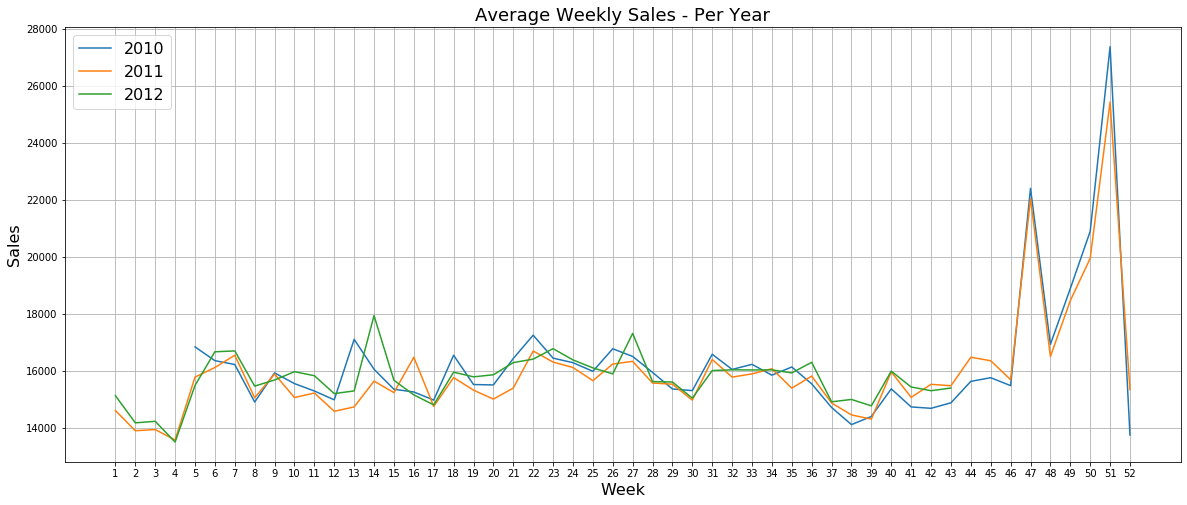

In [15]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

> Görüldüğü gibi -IsHoliday- sütununda bulunmayan başka bir tatil gözümüze çarpıyor.Haftanın günlerinden daima pazartesiye denk gelen PASKALYA yılın farklı haftalarına denk düşmektedir.

>* 2010 da 13.hafta
>* 2011 de 16.hafta
>* 2012 de 14.hafta
>* 2013 de 13.hafta--> test setimiz

> Bu bağlamda bu haftaların satır değerlerini TRUE olarak değiştirebiliriz.

In [16]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

> Bu noktada haftalık satışların aritmetik ortalamalarınıda gösteren bir tablo oluşturalım.


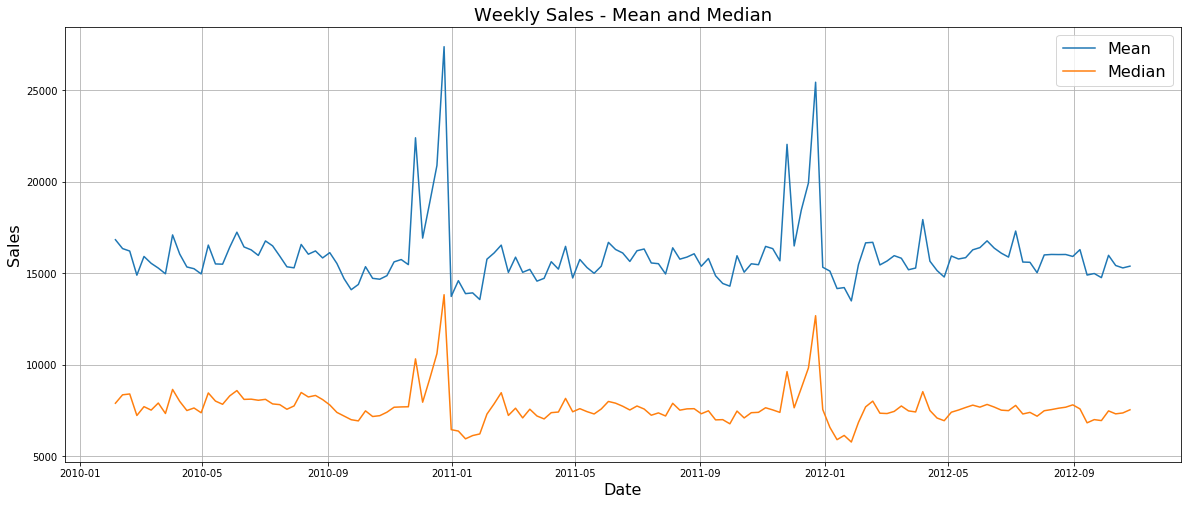

In [17]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

> Bu grafiğe göre ortalama ve medyan değerlerinin epey farklı olduğunu görüyoruz, bu gözlemden bazı bayilerin diğerlerine göre daha çok satış yaptığı sonuucna ulaşabiliriz.

###  Bayi ve Departman Bazında Ortalama Satış

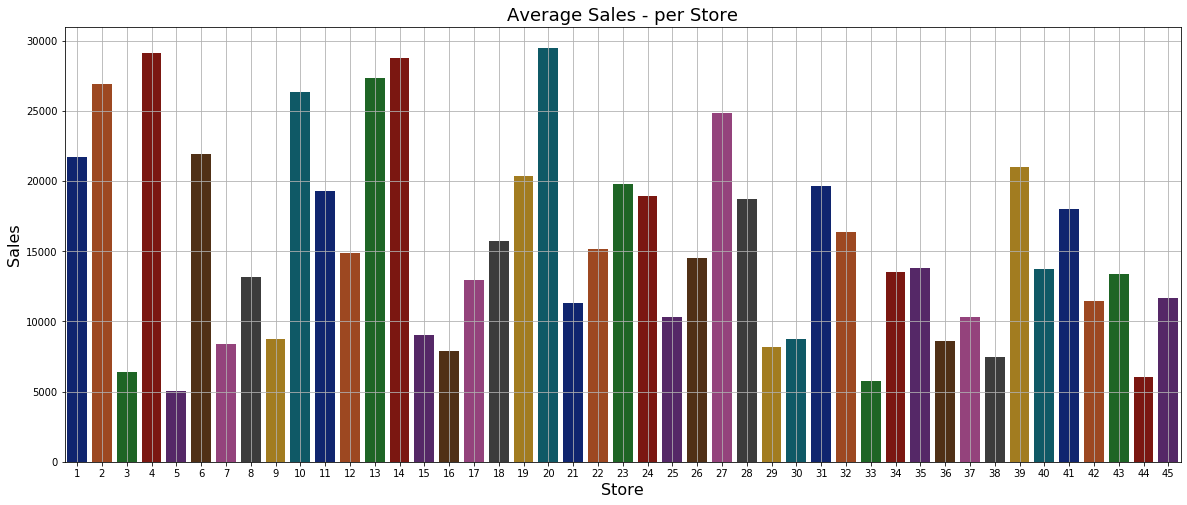

In [18]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

> Görüldüğü gibi bayiler arası satış hacmi farkı mevcut.

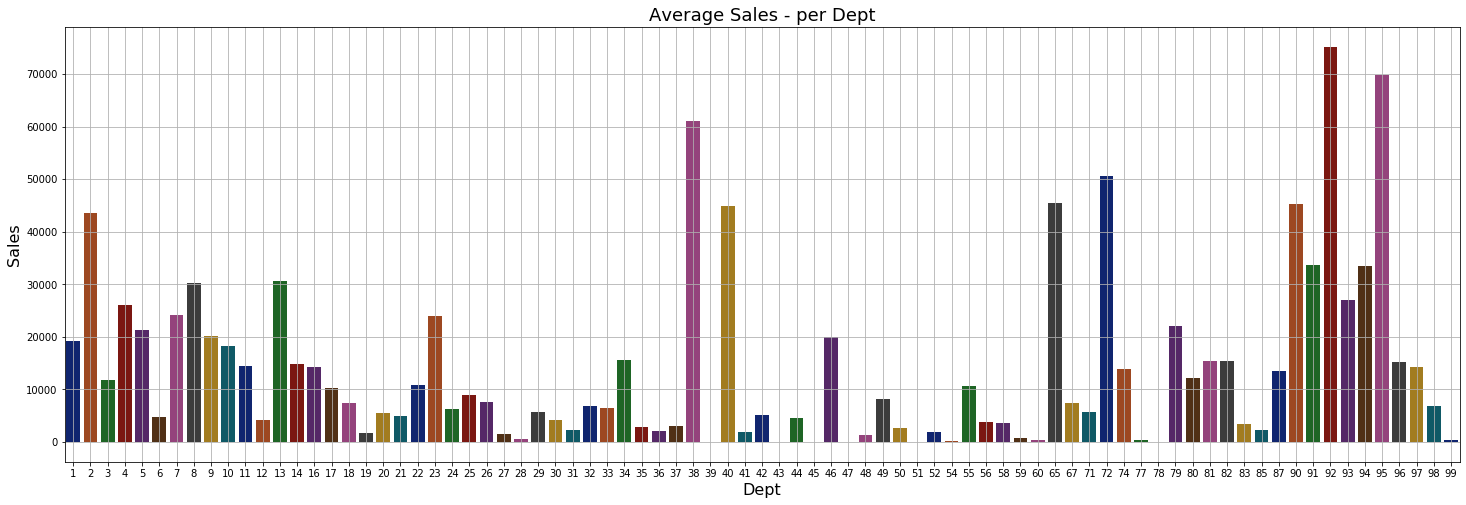

In [19]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

> Yukarıdaki grafiğe istinaden anlıyoruz ki, departmanlar arası satış hacmi farkı mevcut, bazı departmanlar grafikte bulunmamaktadır; mesela 68-69-70 numaralı departmanlar...

###  Değişken Korelasyonu

> Pearson tekniği ile değişkenler arasındaki korelasyona bakalım.

> Korelasyon Metriklerimiz:
    >* 0: Korelasyon bulunmaz
    >* 0-0.3: Zayıf Korelasyon 
    >* 0.3-0.7: Orta Korelasyon
    >* 0.7-1: Güçlü Korelasyon

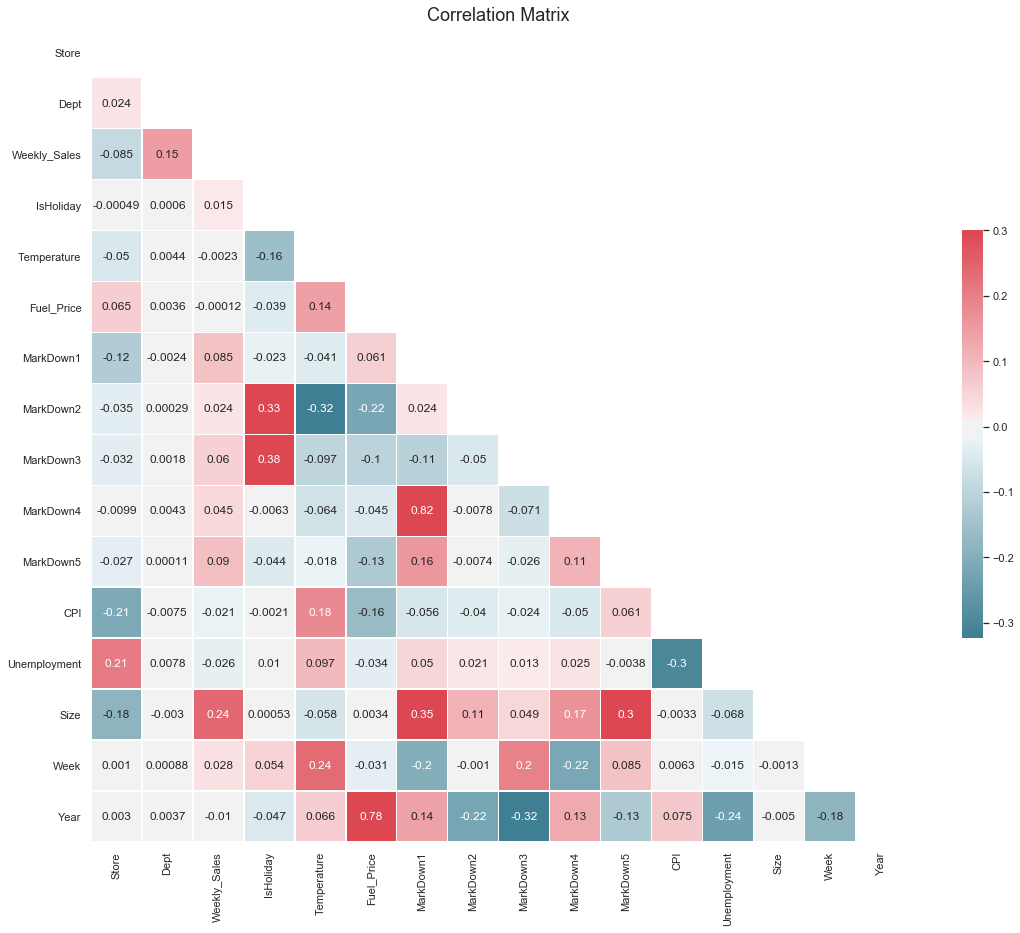

In [20]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

> 'Markdown' 1 den 5 e kadar olan değişkenler haftalık satışlar ile güçlü korelasyon bağı oluşturmadıkları gözlenmektedir. Ayrıa ilgili değişkenlerin içerisinde birçok boş değer bulunduğundan bu değişkenleri direk eleyebiliriz.

> Benzin fiyatları ise Yıl değişkeni ile güçlü bir korelasyon ilişkisi içerisindedir.Bunlardan bir tanesi dışarıda bırakılmalıdır çünkü modelimiz için benzer informasyonları taşıyaaklardır. Bu bağlamda Yıl değişkenini dışarıda bırakamayız çünkü bu değişken Store ve Departman verisetleri için aynı hafta elemanlarını içerisinde barındırmaktadır.

> haftalık satış ile zayıf korelasyona sahip diğer değişkenler ise yararlı olup olmayacaklarına dair analiz edilebilir.

In [21]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

###   Değişken Analizi

> Öndelikle bize yardımcı olacak iki tane ana fonksiyon tanımlamamız gerekmekte.

> ilk fonksiyonumuz tam sayılar için, burada boxplot grafiğini kullanacak olmamızın nedeni medyanları ve kuartil uzunluklarını gözlemlemek. ayrıa stripplot grafiğini de klullandık bunun nedeni dağılımları daha iyi bir biçimde gözlemlemek istememiz...

> continious plot fonksiyonumuz ise sürekli değişkenlerimizi gözlemlemek için kullanacağımız fonksiyon olacak.  Bu fonksiyon aracılığı ile olasılıkların dağılımlarını boxcox yöntemi ile gözlemleyeceğiz. Bu bağlamda korelasyon artışı ve değişkenlerdeki çarpıklık değerlerini gözlemleme şansımız olacak.

In [22]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [23]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

### Weekly_Sales x IsHoliday

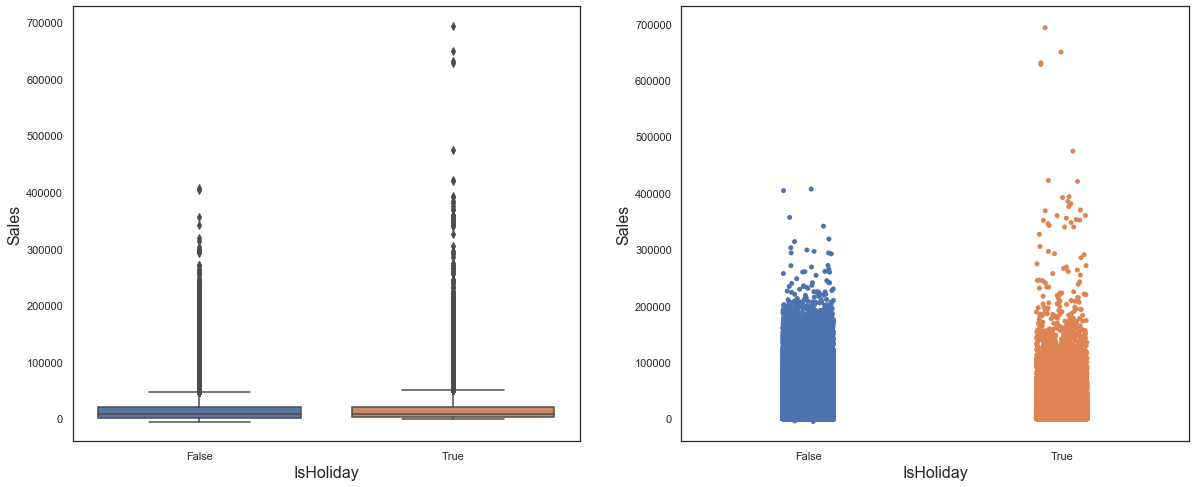

In [24]:
make_discrete_plot('IsHoliday')

> görüldüğü gibi tatil haftaları diğer haftalara oranla daha çok satış başarısına sahip.

### Weekly_Sales x Type

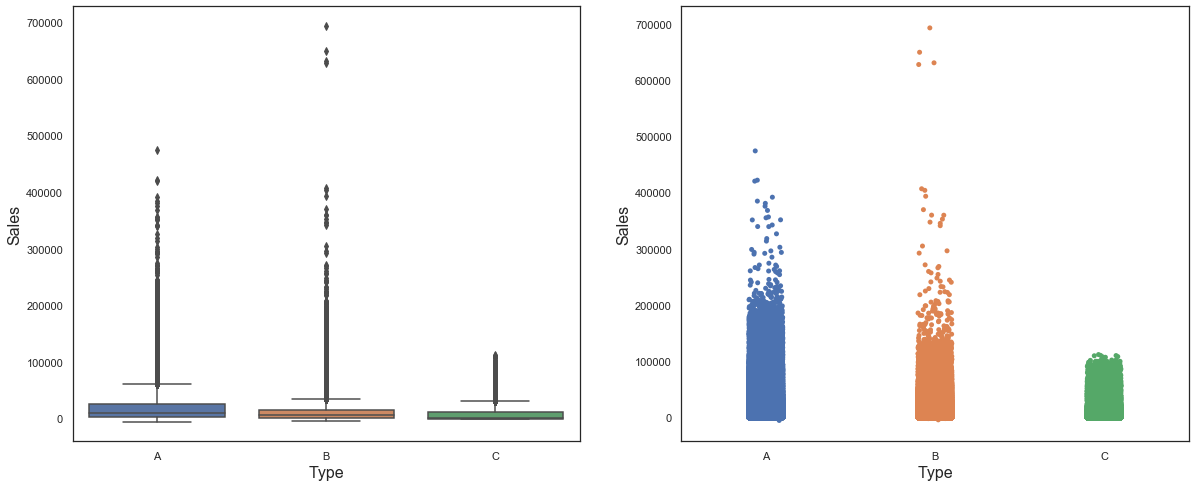

In [25]:
make_discrete_plot('Type')

> 'Type' değişkeni ile ilgili elimizde açıklayıcı bir bilgi yok, fakat Satış Medyanlarına göre A>B>C şeklinde bir sonuca ulaşabiliyoruz. Bu sebeple bu değişkene ordinal bir değişken gibi düşünüp buna göre manipüle edelim.

In [26]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

### Weekly_Sales x Temperature

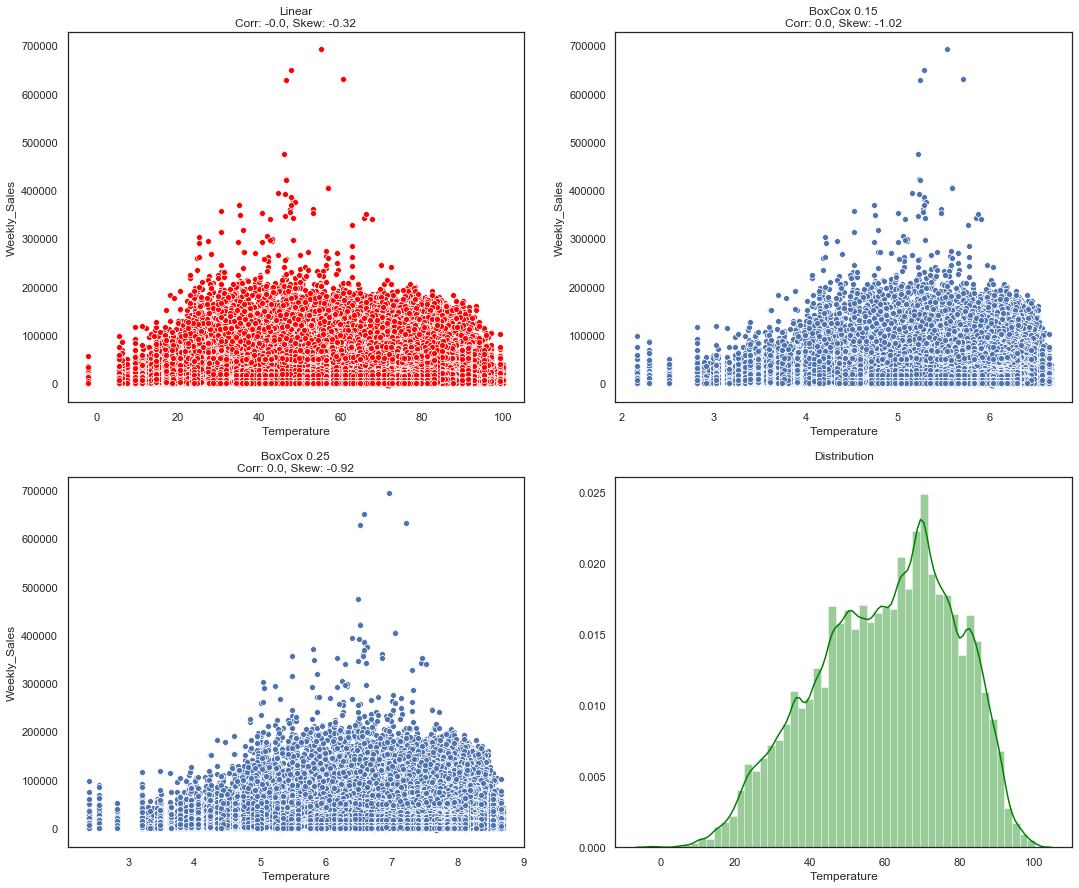

In [27]:
make_continuous_plot('Temperature')

> çarpıklığın değiştiğiniz gözlemlememize rağmen korelasyon değişmemektedir. Bu sebeple bu değişkeni model dışı bırakabiliriz.

In [28]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

### Weekly_Sales x CPI

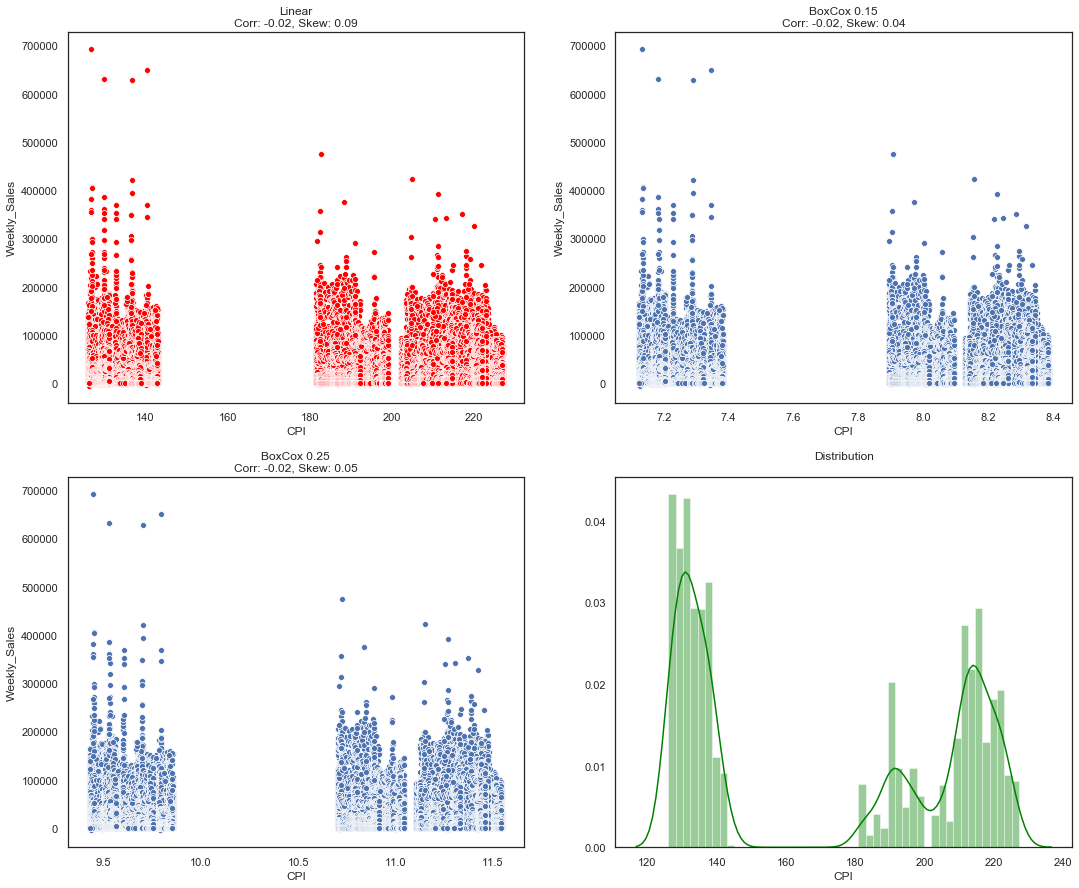

In [29]:
make_continuous_plot('CPI')

> 'CPI' değişkeni içinde aynı şey geçerli.

In [30]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

### Weekly_Sales x Unemployment

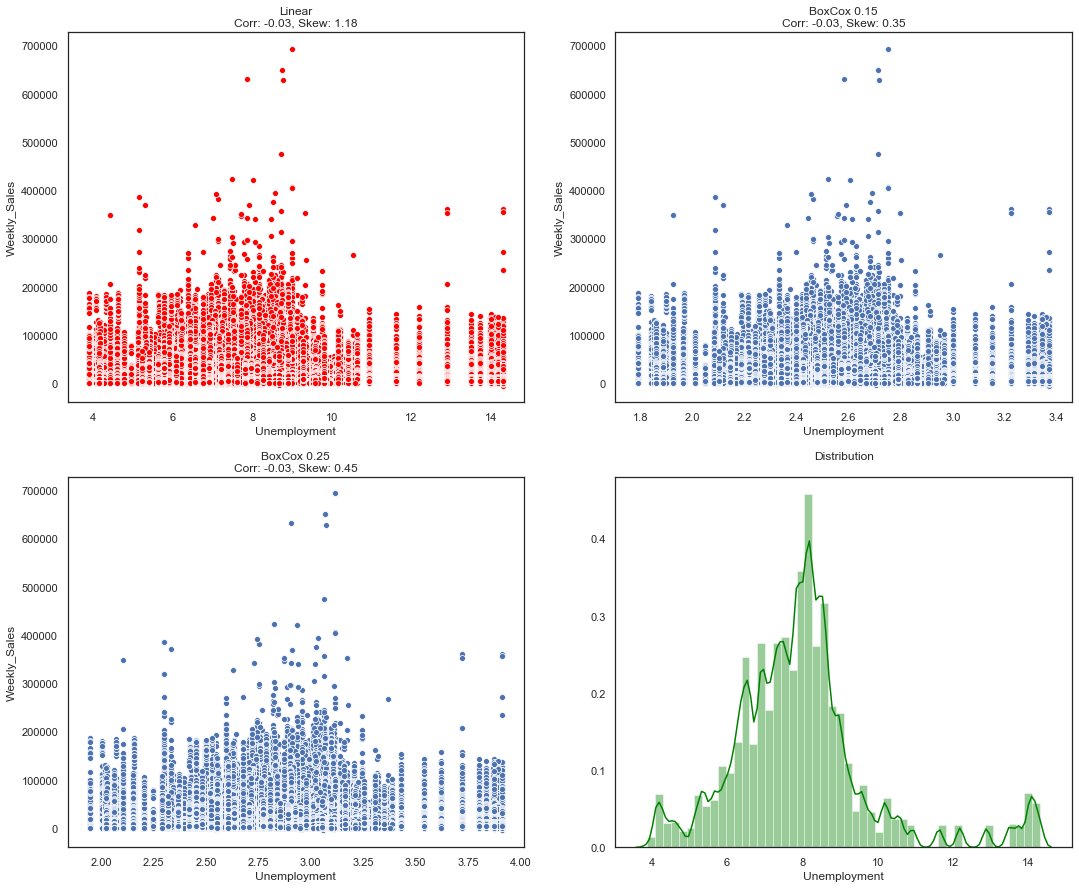

In [31]:
make_continuous_plot('Unemployment')

> 'Unemployment' değişkeni içinde aynı durum söz konusu .

In [32]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

### Weekly_Sales x Size

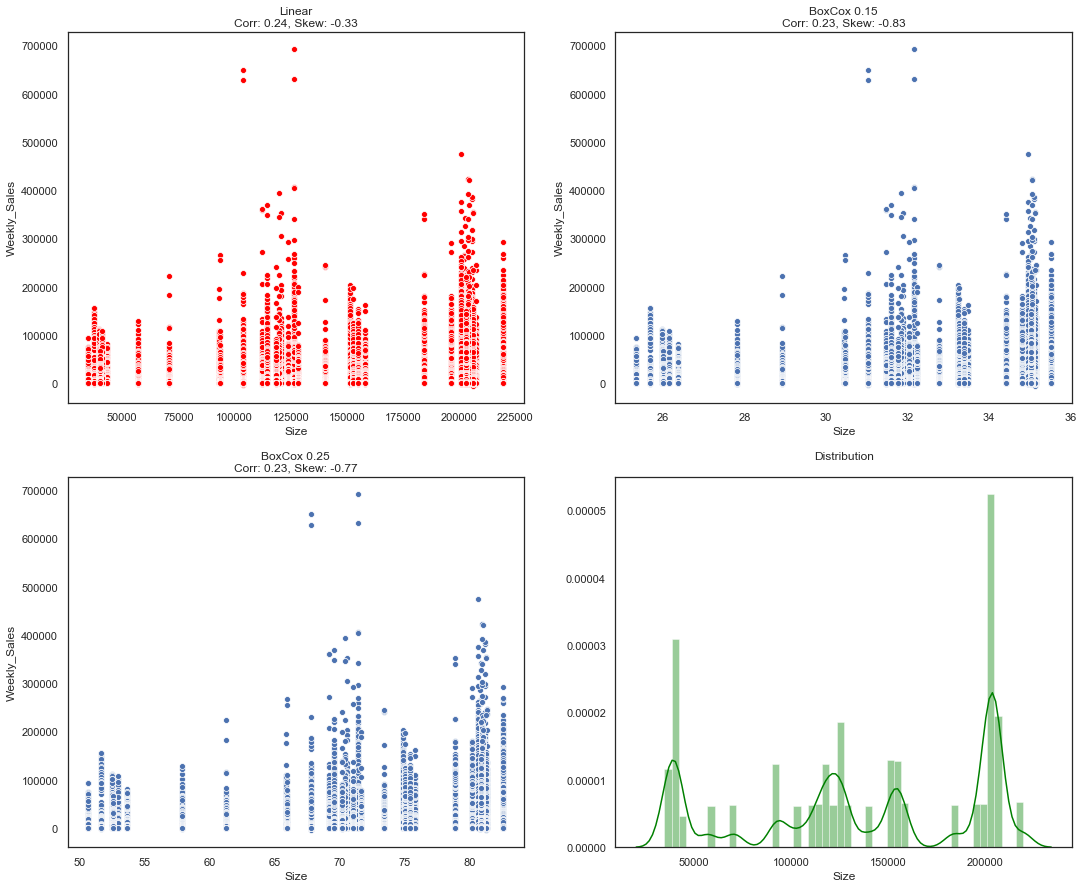

In [33]:
make_continuous_plot('Size')

> görüldüğü üzere yukarıdaki değişken ile devam edebiliriz. haftalık satış ve söz konusu değişken arasında orta seviyede bir korelasyon gözlemlenmektedir.

# 3- Makine Öğrenmesi

> Kurmak istediğimiz modele göre bizim için WMAE yani Weighted mean absolute error katsayısı önemli olacaktır. Tatil haftaları için weight katsayımız 5 diğer günler için 1 olacaktır.

> formülümüzü fonksiyon bazında tune edecegiz(ayarlayacağız). Çünkü elimizdeki verilere göre tune işlemi sırasında GridSearchCV veya RandomSearhCV kullanamamaktayız.

In [34]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

> RANROM FOREST REGRESSOR 

In [35]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [36]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [37]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

### Training Modeli

> Train setimizi hazırlayalım.

In [38]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

> 'n_estimators' ve 'max_depth' parametrelerinin tuning işlemi.

> Bu kısımda birçok değeri test edilebilir, edilmelidir. Aşağıdaki değerler, birçok testten sonra karar verilmiş final değerleridir.



In [39]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1547.2125
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1543.135
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1532.0625
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1543.8025
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1535.37
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k: 

,Max_Depth,Estimators,WMAE
0,25,56,1547.2125
1,27,56,1543.1350
2,30,56,1532.0625
3,25,58,1543.8025
4,27,58,1535.3700
5,30,58,1531.5325
6,25,60,1536.6825
7,27,60,1559.2150
8,30,60,1534.0125


2 numaralı hiperparametreleri kullanalım.

> 'max_features' tuning işlemi.

In [47]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=56, max_depth=30, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4561.08
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2665.0
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1772.0
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1560.0975
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1536.1000000000001
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1559.3625000000002


,Max_Feature,WMAE
0,2,4561.0800
1,3,2665.0000
2,4,1772.0000
3,5,1560.0975
4,6,1536.1000
5,7,1559.3625


> 4 numaralı hiperparametreleri kullanalım.

> 'min_samples_split' ve 'min_samples_leaf' tuning işlemleri.

In [48]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=56, max_depth=30, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1553.8925
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1585.71
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1633.3024999999998
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1543.9099999999999
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_s

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1553.8925
1,2,2,1585.7100
2,3,2,1633.3025
3,1,3,1543.9100
4,2,3,1573.9075
5,3,3,1634.2750
6,1,4,1536.9425
7,2,4,1588.3525
8,3,4,1646.8875


> 6 numaralı hiperparametreleri kullanıp son modelimizi oluşturalım;

> Son modelimiz:

In [49]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=4, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=4,
                      n_estimators=58)

### Predictions TAHMİNLER

In [50]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

# 4-Christmas Adjustment   Noel Ayarlaması

> Hatırlayacağımız gibi 2010 yılında noel haftası 0 tatil önecesi promosyon gününe sabitti. 2011 de ise 1 ve 2012 de 3 gün şeklindeydi. Bu bağlamda 2012-2010 yılları arasında 3 gün, 2012-2011 yılları arasındada 2 gün olarak incelemiştik. Bunların ortalaması haftalık 2.5 gün şeklinde olacaktır. 2.5 aritmetik ortalama değeri Week 51 ile çarpılıp Week 52 ye eklenmelidir ki modelimiz daha tutarlı bir tahmin yapabilsin. Bu formülü sadece 'Stores'+'Departments' değişkenleri için kullanacağız çünkü ilgili haftalarda bu aylarda büyük satış farkları gözlemlenmekte. Axiom olarak burada Week51 > 2 * Week52 şeklinde düşünebiliriz.



> Bu durumu hızlıa çözmek için başka bir DataFrame ve sql düzeneği oluşturalım...

In [51]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [52]:
Final_adj = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")

In [53]:
sample_submission['Weekly_Sales'] = Final_adj['Weekly_Sales_Adjusted']
sample_submission.to_csv('submission.csv',index=False)